In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
data='./kaggle_asl/asl_alphabet_train/asl_alphabet_train'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [11]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


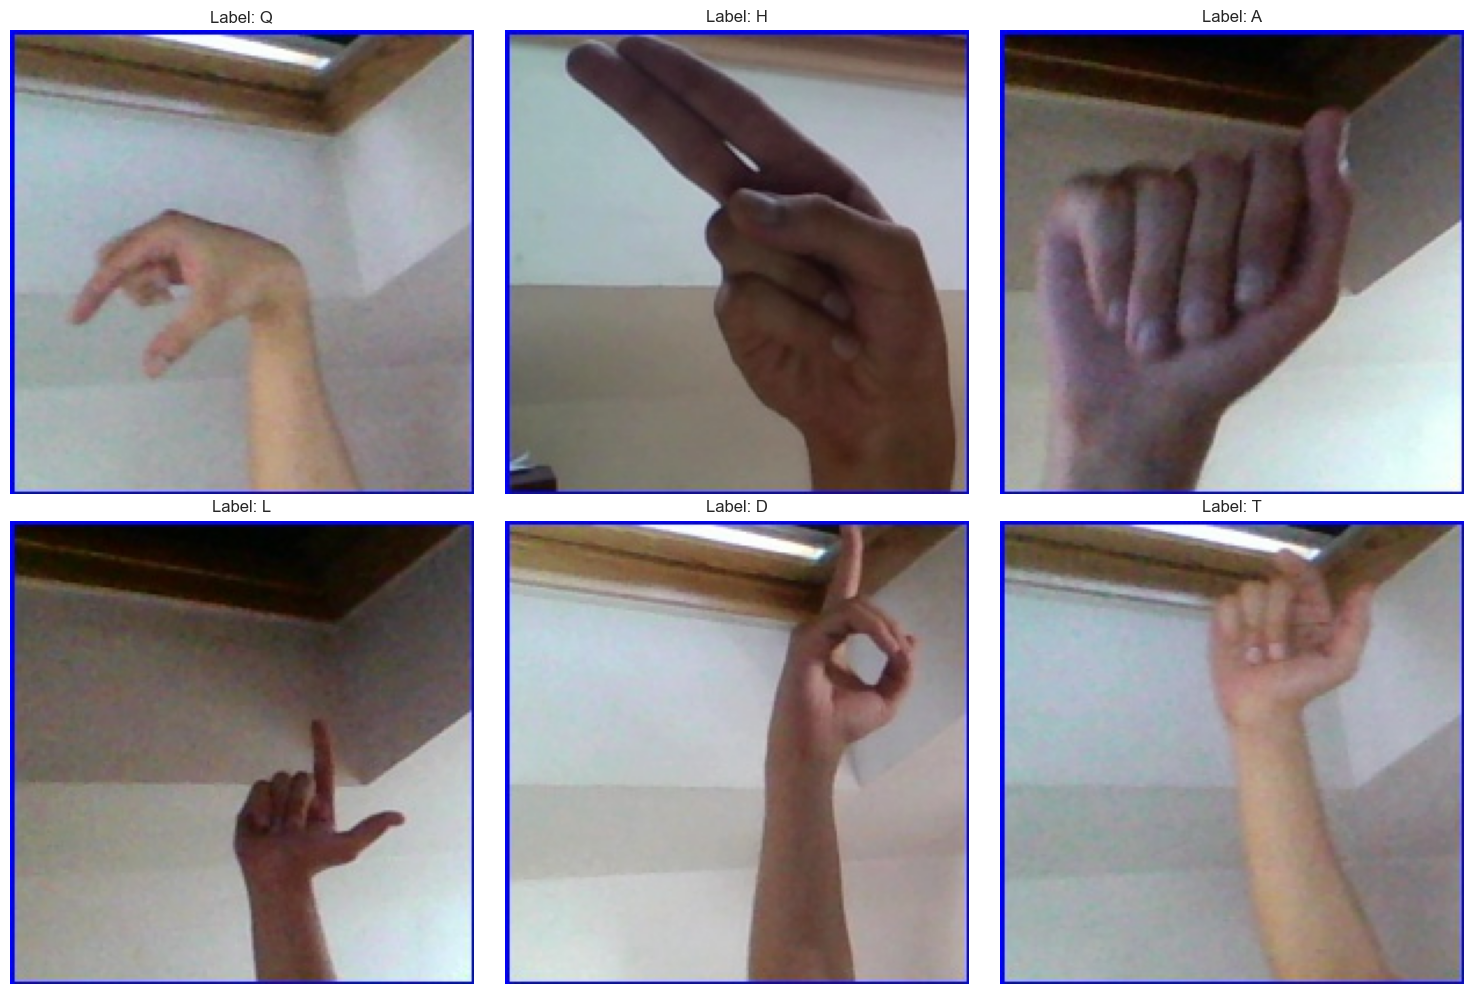

In [13]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

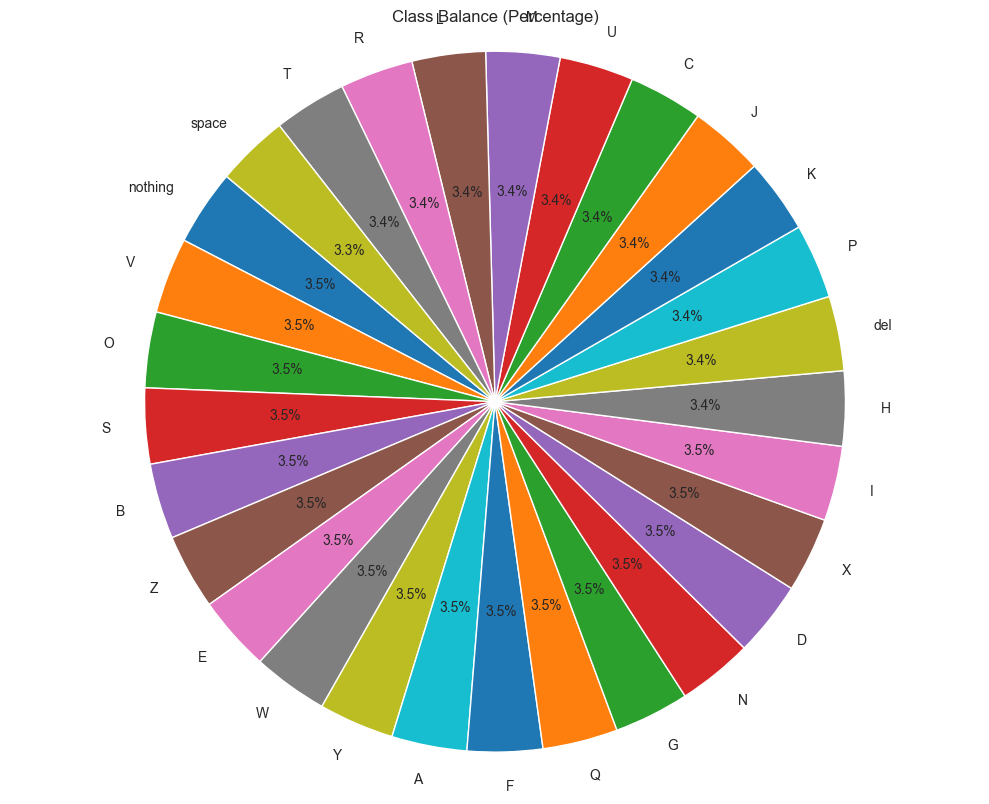

In [14]:
# Calculate class counts
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(train_df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [15]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (150,150,3) ,
                                                     pooling = 'max' )

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(29 , activation= 'softmax' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
history = model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 5 , verbose = 1 ,
    validation_steps= None, shuffle= False
   )

83683744/83683744 [==============================] - 3s 0us/step
Epoch 1/5
 391/1392 [=======>......................] - ETA: 41:09 - loss: 0.7526 - accuracy: 0.8021

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()